## Notebook Setup

### Imports

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages

sns.set_color_codes()
# sns.set_theme()
sns.set_context("paper")

In [2]:
import re
from pathlib import Path
from pprint import pprint
from multiprocessing import Pool

import pandas as pd
import numpy as np
from tqdm.auto import tqdm

from info_salience import utils

### Colormap

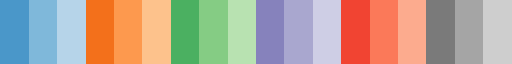

In [3]:
import matplotlib

N = 3
base_cmaps = ['Blues', 'Oranges', 'Greens', 'Purples','Reds', 'Greys']

n_base = len(base_cmaps)
# we go from 0.3 to 0.7 below to avoid having several whites and blacks in the resulting cmaps
colors = np.concatenate([plt.get_cmap(name)(sorted(np.linspace(0.3,0.6,N), reverse=True)) for name in base_cmaps])
cmap = matplotlib.colors.ListedColormap(colors)
cmap

In [4]:
########################
# Model colors
########################
MODEL_MAP = {
    "greedy": "Greedy",
    "random": "Random",
    "lead_1": "Lead 1",
    "lead_n": "Lead N",
    "textrank": "TextRank",

    "OLMo-7B-Instruct-hf": "OLMo (7B)",
    "OLMo-7B-0724-Instruct-hf": "OLMo 0724 (7B)",

    "Mistral-7B-Instruct-v0.3": "Mistral (7B)",
    "Mixtral-8x7B-Instruct-v0.1": "Mixtral (8x7B)",

    "Llama-2-7b-chat-hf": "Llama 2 (7B)",
    "Llama-2-13b-chat-hf": "Llama 2 (13B)",
    "Llama-2-70b-chat-hf": "Llama 2 (70B)",

    "Meta-Llama-3-8B-Instruct": "Llama 3 (8B)",
    "Meta-Llama-3-70B-Instruct": "Llama 3 (70B)",

    "Meta-Llama-3.1-8B-Instruct": "Llama 3.1 (8B)",
    "Meta-Llama-3.1-70B-Instruct": "Llama 3.1 (70B)",

    "Meta-Llama-3.1-8B-Instruct-quantized.w8a8": "Llama 3.1 (8B_Q8)",
    "Meta-Llama-3.1-70B-Instruct-quantized.w8a8": "Llama 3.1 (70B_Q8)",

    "gpt-4o-mini-2024-07-18": "GPT-4o-mini (07/24)",
    "gpt-4o-2024-08-06": "GPT-4o (08/24)",    
}


def model_ids_to_display_name(model_ids):
    return [MODEL_MAP[model_id] for model_id in model_ids]


def model_ids_to_display_order(model_ids):
    model_ids = set(model_ids)
    assert all((model_id in MODEL_MAP for model_id in model_ids))
    return [v for k, v in MODEL_MAP.items() if k in model_ids]


########################
# Model colors
########################

COLOR_MAP = {
    # blue
    'Meta-Llama-3.1-8B-Instruct': cmap(0),
    'Meta-Llama-3.1-70B-Instruct': cmap(1),

    # orange
    'Meta-Llama-3-8B-Instruct': cmap(3),
    'Meta-Llama-3-70B-Instruct': cmap(4),

    # greens
    'Llama-2-7b-chat-hf': cmap(6),
    'Llama-2-13b-chat-hf': cmap(7),
    'Llama-2-70b-chat-hf': cmap(8),
    
    # purples
    'gpt-4o-mini-2024-07-18': cmap(9),
    'gpt-4o-2024-08-06': cmap(10),

    # reds
    'Mistral-7B-Instruct-v0.3': cmap(12),
    'Mixtral-8x7B-Instruct-v0.1': cmap(13),
       
    # grays
    'OLMo-7B-Instruct-hf': cmap(15),
    'OLMo-7B-0724-Instruct-hf': cmap(16),


    "greedy": cmap(17),
    "random": cmap(17),
    "lead_1": cmap(17),
    "lead_n": cmap(17),
    "textrank": cmap(17),
}


def model_ids_to_display_color(model_ids):
    model_ids = set(model_ids)
    return {MODEL_MAP[model_id]: COLOR_MAP[model_id] for model_id in model_ids}

### Calculating incremental consistency

In [5]:
def incremental_consistency(nli_matrix, normalize_entailed=False, entail_label=1):
    result = []
    for row in nli_matrix:
        try:
            first = list(row).index(entail_label)
        except ValueError:
            if normalize_entailed:
                result.append(np.nan)
                continue
            else:
                first = len(row)

        if all(label == entail_label for label in row[first + 1 :]):
            result.append(True)
        else:
            result.append(False)

    result = np.array(result)
    return np.nanmean(result), result 


x = np.array(
    [
        [0, 0, 0, 0],
        [1, 1, 0, 0],
        [1, 1, 1, 1],
        [1, 0, 1, 0],
        [2, 1, 0, 1],
        [1, 1, 1, 0],
    ]
)

score, labels = incremental_consistency(x, entail_label=0)
assert score == 4/6
assert np.array_equal(labels, np.array([True, True, True, False, False, True]))

score, labels = incremental_consistency(x, entail_label=0, normalize_entailed=True)
assert score == 3/5
assert np.array_equal(labels, np.array([True, True, np.nan, False, False, True]), equal_nan=True)

### Data loading

In [6]:
def extract_temperature(s):
    temperature = re.search(r"temperature(\d\.\d+)", s)
    if temperature:
        return float(temperature.group(1))
    return None


def extract_repeat(s):
    repeat = re.search(r"-(\d).json", s)
    if repeat:
        return int(repeat.group(1))
    return None


def load_and_calculate(nli_path):
    nli_path = Path(nli_path)  # ex: ../output/pubmed-sample/Mixtral-8x7B-Instruct-v0.1/nli/temperature0.5-3.json
    model = nli_path.parents[1].name
    dataset = nli_path.parents[2].name
    temperature = extract_temperature(nli_path.name)
    repeat = extract_repeat(nli_path.name)

    variables = [
        'summary_10w_nli_pred',
        'summary_20w_nli_pred',
        'summary_50w_nli_pred',
        'summary_100w_nli_pred',
        'summary_200w_nli_pred',
    ]

    df = pd.read_json(nli_path)
    df = df[variables]
    score, labels = incremental_consistency(df.values, normalize_entailed=True, entail_label=1)

    return {
        'dataset': dataset,
        'model': model,
        'temperature': temperature, 
        'repeat': repeat,
        'consistency': score
    }


def load_all_runs(paths):
    with Pool(14) as p:
        results = list(tqdm(p.imap(load_and_calculate, paths), total=len(paths)))    
    return pd.DataFrame(results)

In [7]:
print(load_and_calculate('../output/pubmed-sample/gpt-4o-2024-08-06/discord-qa-nli/temperature0.3-0.json'))

load_all_runs([
    '../output/pubmed-sample/gpt-4o-2024-08-06/discord-qa-nli/temperature0.3-0.json',
    '../output/pubmed-sample/gpt-4o-2024-08-06/discord-qa-nli/temperature0.3-1.json',
    '../output/pubmed-sample/gpt-4o-2024-08-06/discord-qa-nli/temperature0.3-2.json',
    '../output/pubmed-sample/gpt-4o-2024-08-06/discord-qa-nli/temperature0.3-3.json',
    '../output/pubmed-sample/gpt-4o-2024-08-06/discord-qa-nli/temperature0.3-4.json',
])

{'dataset': 'pubmed-sample', 'model': 'gpt-4o-2024-08-06', 'temperature': 0.3, 'repeat': 0, 'consistency': 0.932344466972575}


  0%|          | 0/5 [00:00<?, ?it/s]

,dataset,model,temperature,repeat,consistency
0,pubmed-sample,gpt-4o-2024-08-06,0.3,0,0.932344
1,pubmed-sample,gpt-4o-2024-08-06,0.3,1,0.934001
2,pubmed-sample,gpt-4o-2024-08-06,0.3,2,0.929791
3,pubmed-sample,gpt-4o-2024-08-06,0.3,3,0.935601
4,pubmed-sample,gpt-4o-2024-08-06,0.3,4,0.930930


## Analysis

In [8]:
run_files = list(Path('../output/').glob('**/**/discord-qa-nli/*.json'))
df = load_all_runs(run_files)

exclude_models = [
    "Meta-Llama-3.1-8B-Instruct-quantized.w8a8",
    "Meta-Llama-3.1-70B-Instruct-quantized.w8a8"
]

df = df[~df['model'].isin(exclude_models)]
df = df.reset_index(drop=True)
df.head()

  0%|          | 0/1354 [00:00<?, ?it/s]

,dataset,model,temperature,repeat,consistency
0,pubmed-sample,gpt-4o-mini-2024-07-18,0.3,1.0,0.929470
1,pubmed-sample,gpt-4o-mini-2024-07-18,0.3,0.0,0.925505
2,pubmed-sample,gpt-4o-mini-2024-07-18,0.3,4.0,0.924360
3,pubmed-sample,gpt-4o-mini-2024-07-18,0.3,2.0,0.929708
4,pubmed-sample,gpt-4o-mini-2024-07-18,0.3,3.0,0.928051


In [9]:
order = model_ids_to_display_order(df['model'])
df.groupby(['dataset', 'model']).size().unstack().T.rename(MODEL_MAP).loc[order]

dataset,astro-ph,cs-cl,dummy,pubmed-sample,qmsum-generic
model,,,,,
Greedy,1.0,1.0,1.0,1.0,1.0
Random,5.0,5.0,5.0,3.0,5.0
Lead 1,1.0,1.0,1.0,1.0,1.0
Lead N,1.0,1.0,1.0,1.0,1.0
TextRank,1.0,1.0,1.0,1.0,1.0
OLMo (7B),5.0,5.0,NaN,101.0,NaN
OLMo 0724 (7B),5.0,5.0,NaN,101.0,NaN
Mistral (7B),5.0,5.0,NaN,101.0,10.0
Mixtral (8x7B),5.0,5.0,NaN,101.0,5.0


## Heatmap

In [10]:
models = [
    'textrank',
    'random',
    # 'greedy',
    # 'lead_1',
    # 'lead_n',
    
    'OLMo-7B-Instruct-hf',
    'OLMo-7B-0724-Instruct-hf',

    'Mistral-7B-Instruct-v0.3',
    'Mixtral-8x7B-Instruct-v0.1',
    
    'Llama-2-7b-chat-hf',
    'Llama-2-13b-chat-hf',
    'Llama-2-70b-chat-hf',
    
    'Meta-Llama-3-8B-Instruct',
    'Meta-Llama-3-70B-Instruct',
    
    'Meta-Llama-3.1-8B-Instruct',
    'Meta-Llama-3.1-70B-Instruct',

    'gpt-4o-mini-2024-07-18',
    'gpt-4o-2024-08-06',
]

stats = df[
    ((df['temperature'] == 0.3) | df['temperature'].isna())
    & df['model'].isin(models)
    & df['dataset'].isin(['astro-ph', 'cs-cl', 'pubmed-sample', 'qmsum-generic'])
]
stats = stats.pivot_table(index='model', columns='dataset', values='consistency')
# calculate row-wise and column-wise mean
stats['all'] = stats.mean(axis=1)
stats.loc['Avg.'] = stats.mean()


# Rename and reorder
stats = stats.loc[models + ['Avg.']]
stats = stats[['all', 'pubmed-sample', 'astro-ph', 'cs-cl', 'qmsum-generic']]
stats = stats.rename(MODEL_MAP, axis=0)
stats = stats.rename({
    'all': 'All',
    'pubmed-sample': 'RCT',
    'astro-ph': 'Astro',
    'cs-cl': 'CL',
    'qmsum-generic': 'QMSum'
}, axis=1)
stats = stats.rename_axis(None, axis=1)
# stats = stats.reset_index()
display(stats)

,All,RCT,Astro,CL,QMSum
model,,,,,
TextRank,0.953133,0.969147,0.955847,0.937035,0.950504
Random,0.599893,0.585595,0.585862,0.625847,0.602268
OLMo (7B),0.636442,0.754950,0.566621,0.587754,NaN
OLMo 0724 (7B),0.748082,0.851618,0.686098,0.706529,NaN
Mistral (7B),0.735482,0.853822,0.718592,0.729086,0.640427
Mixtral (8x7B),0.798070,0.905987,0.797047,0.790807,0.698440
Llama 2 (7B),0.724106,0.802268,0.686677,0.683371,NaN
Llama 2 (13B),0.745184,0.824902,0.719827,0.690823,NaN
Llama 2 (70B),0.791060,0.881114,0.753758,0.738308,NaN


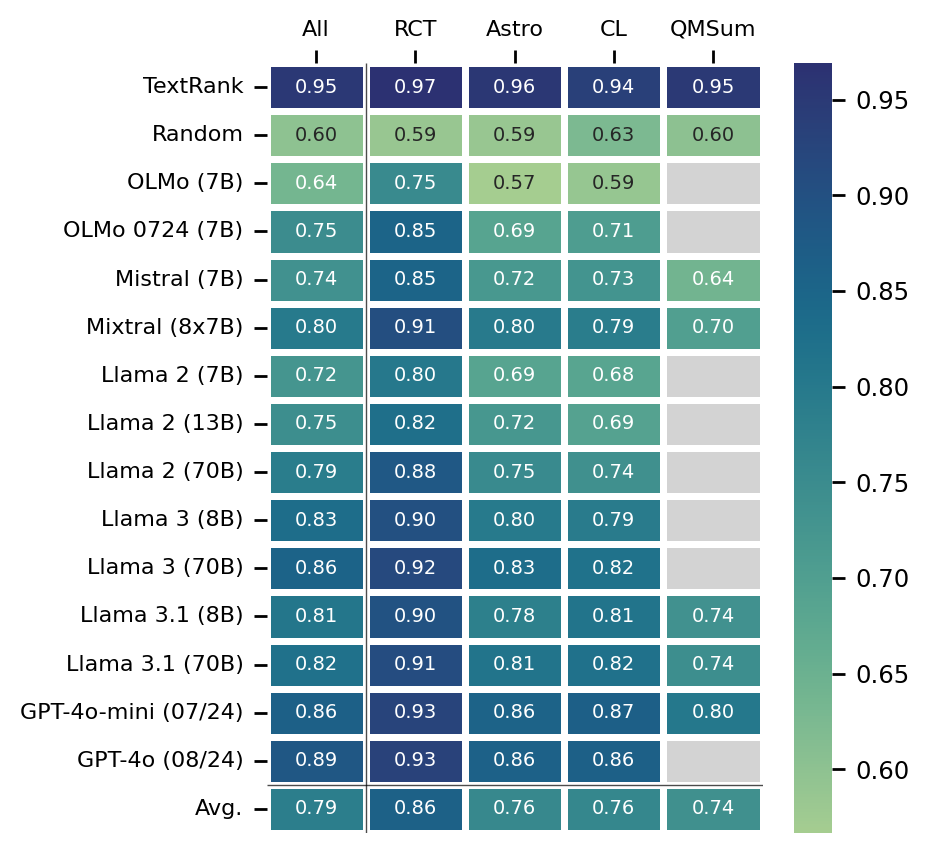

In [11]:
fig = plt.figure(figsize=(4, 5))
ax = sns.heatmap(stats, annot=True, linewidth=2.5, cmap="crest", annot_kws={"fontsize":7}, fmt='.2f')

ax.collections[0].cmap.set_bad('lightgray')

plt.tick_params(axis='both', which='both', labelbottom = False, bottom=False, top = True, labeltop=True)

# Draw line after first column / before last row to set apart the averages
plt.hlines(stats.shape[0]-1, *ax.get_xlim(), colors='black', linewidth=0.5, alpha=0.7)
plt.vlines(1, *ax.get_ylim(), colors='black', linewidth=0.5, alpha=0.7)

plt.xticks(fontsize=8);
plt.yticks(fontsize=8);
plt.ylabel(None);

utils.savefig(fig, name='ic', formats=['pdf'], path='../output/figures-paper/')

## Lineplot

In [13]:
models = [
    'textrank',
    'random',
    # 'greedy',
    # 'lead_1',
    # 'lead_n',
    
    'OLMo-7B-Instruct-hf',
    'OLMo-7B-0724-Instruct-hf',

    'Mistral-7B-Instruct-v0.3',
    'Mixtral-8x7B-Instruct-v0.1',
    
    'Llama-2-7b-chat-hf',
    'Llama-2-13b-chat-hf',
    'Llama-2-70b-chat-hf',
    
    'Meta-Llama-3-8B-Instruct',
    'Meta-Llama-3-70B-Instruct',
    
    'Meta-Llama-3.1-8B-Instruct',
    'Meta-Llama-3.1-70B-Instruct',

    'gpt-4o-mini-2024-07-18',
    'gpt-4o-2024-08-06',
]

stats = df[
    ((df['temperature'] == 0.3) | df['temperature'].isna())
    & df['model'].isin(models)
    & df['dataset'].isin(['astro-ph', 'cs-cl', 'pubmed-sample', 'qmsum-generic'])
]
stats = stats.pivot_table(index='model', columns='dataset', values='consistency')
stats = stats.loc[models]
stats['all'] = stats.mean(axis=1)
display(stats)

stats_long = stats.reset_index().melt(id_vars=['model'], value_name='score')
display(stats_long.head())

dataset,astro-ph,cs-cl,pubmed-sample,qmsum-generic,all
model,,,,,
textrank,0.955847,0.937035,0.969147,0.950504,0.953133
random,0.585862,0.625847,0.585595,0.602268,0.599893
OLMo-7B-Instruct-hf,0.566621,0.587754,0.754950,NaN,0.636442
OLMo-7B-0724-Instruct-hf,0.686098,0.706529,0.851618,NaN,0.748082
Mistral-7B-Instruct-v0.3,0.718592,0.729086,0.853822,0.640427,0.735482
Mixtral-8x7B-Instruct-v0.1,0.797047,0.790807,0.905987,0.698440,0.798070
Llama-2-7b-chat-hf,0.686677,0.683371,0.802268,NaN,0.724106
Llama-2-13b-chat-hf,0.719827,0.690823,0.824902,NaN,0.745184
Llama-2-70b-chat-hf,0.753758,0.738308,0.881114,NaN,0.791060


,model,dataset,score
0,textrank,astro-ph,0.955847
1,random,astro-ph,0.585862
2,OLMo-7B-Instruct-hf,astro-ph,0.566621
3,OLMo-7B-0724-Instruct-hf,astro-ph,0.686098
4,Mistral-7B-Instruct-v0.3,astro-ph,0.718592


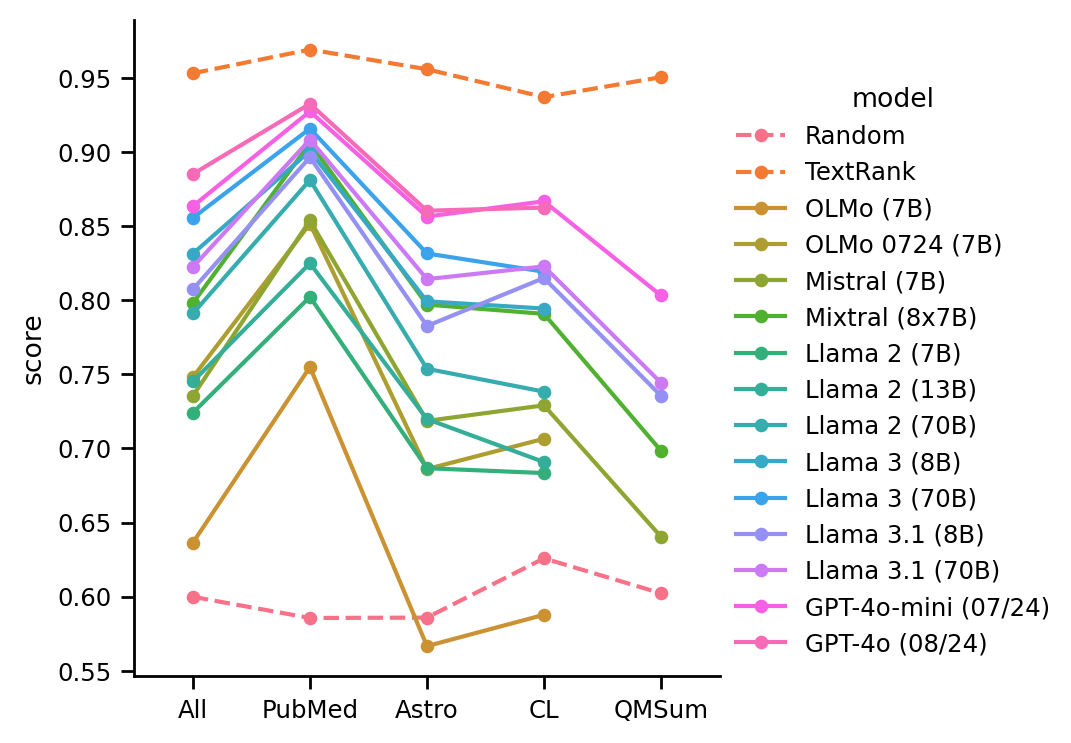

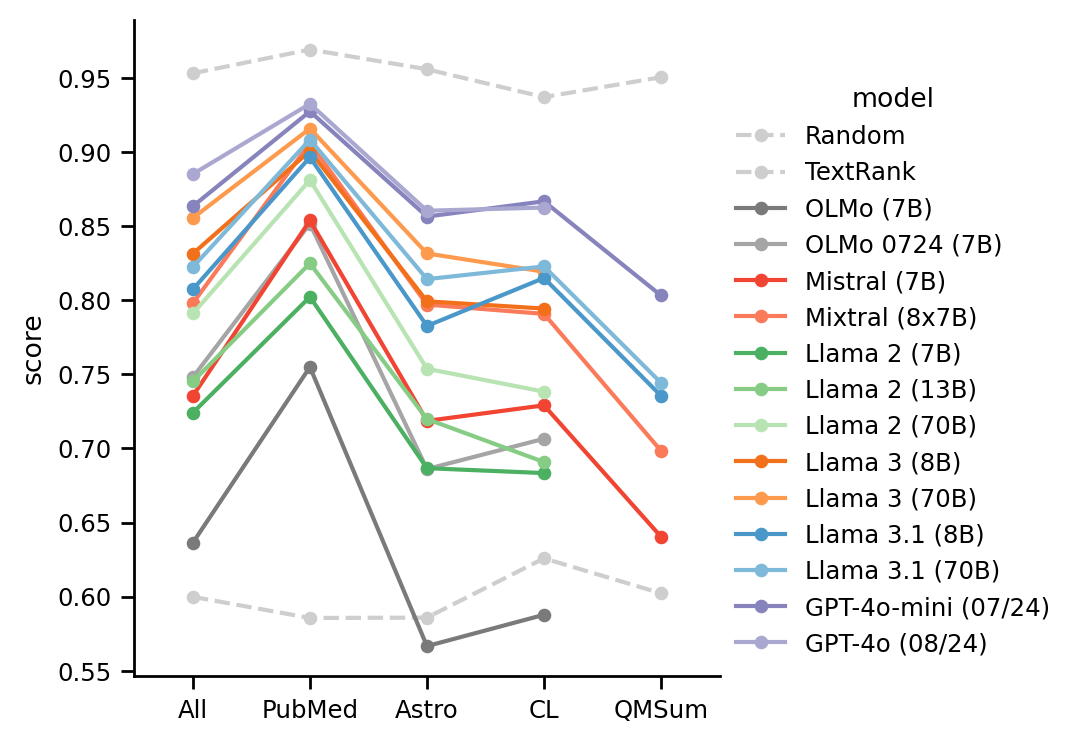

In [14]:
dataset_rename = {
    'all': 'All',
    'pubmed-sample': 'RCT',
    'astro-ph': 'Astro',
    'cs-cl': 'CL',
    'qmsum-generic': 'QMSum'
}

x = stats_long.copy()
order = model_ids_to_display_order(x['model'])
color = model_ids_to_display_color(x['model'])
x['model'] = model_ids_to_display_name(x['model'])
x['dataset'] = x['dataset'].apply(lambda x: dataset_rename[x])

g = sns.catplot(
    data=x,
    x="dataset",
    y="score",
    hue="model",
    hue_order=order,
    order=list(dataset_rename.values()),
    kind='point',
    linestyles=['--', '--'] + ['-']*(len(order)-2),
    legend_out=True,
    height=4,
    linewidth=1.5,
)
g.set(xlabel=None)


g = sns.catplot(
    data=x,
    x="dataset",
    y="score",
    hue="model",
    hue_order=order,
    palette=color,
    order=list(dataset_rename.values()),
    kind='point',
    linestyles=['--', '--'] + ['-']*(len(order)-2),
    legend_out=True,
    height=4,
    linewidth=1.5,
)
g.set(xlabel=None)

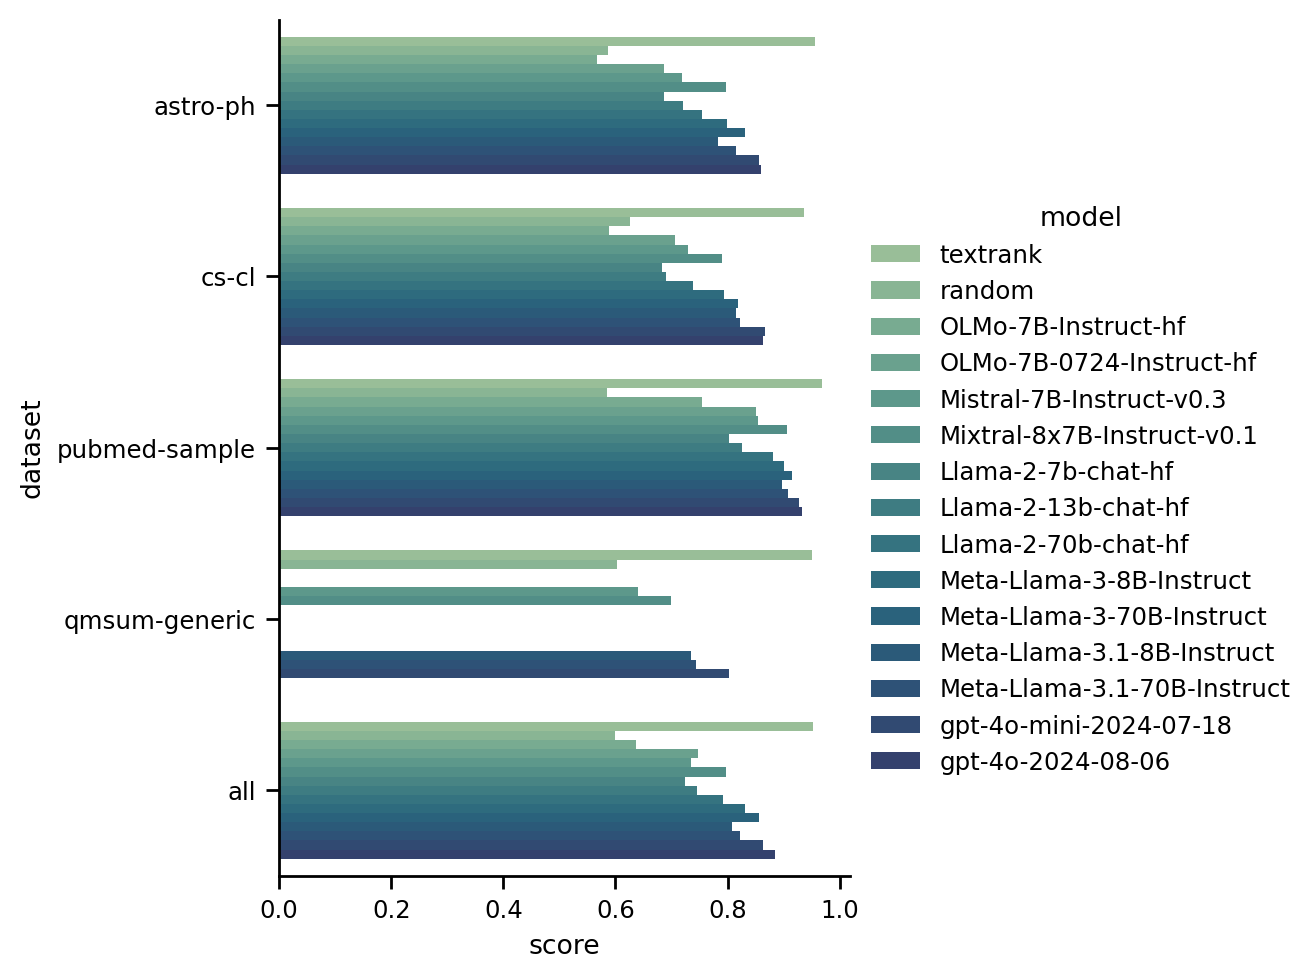

In [15]:
sns.catplot(
    stats_long,
    kind='bar',
    x='score',
    y='dataset',
    hue='model',
    palette='crest'
)

## Incremental consistency temperature sweep

In [16]:
temp_sweep_models = [
    'Llama-2-13b-chat-hf',
    'Llama-2-70b-chat-hf',
    'Llama-2-7b-chat-hf',
    'Meta-Llama-3-70B-Instruct',
    'Meta-Llama-3-8B-Instruct',
    'Meta-Llama-3.1-70B-Instruct',
    'Meta-Llama-3.1-8B-Instruct',
    'Mistral-7B-Instruct-v0.3',
    'Mixtral-8x7B-Instruct-v0.1',
    'OLMo-7B-0724-Instruct-hf',
    'OLMo-7B-Instruct-hf'
]

df_temp_sweep = df[
    (df['dataset'] == 'pubmed-sample')
    & df['model'].isin(temp_sweep_models)
]

# Duplicate with 0 so that confidence bands are not cutoff
df_temp_sweep = pd.concat([
    df_temp_sweep[df_temp_sweep['temperature'] == 0],
    df_temp_sweep
], ignore_index=True)

In [17]:
fixed_models = [
    'textrank',
    'random',
    'gpt-4o-2024-08-06'
]

df_fixed = df[
    (df['dataset'] == 'pubmed-sample')
    & df['model'].isin(fixed_models)
]

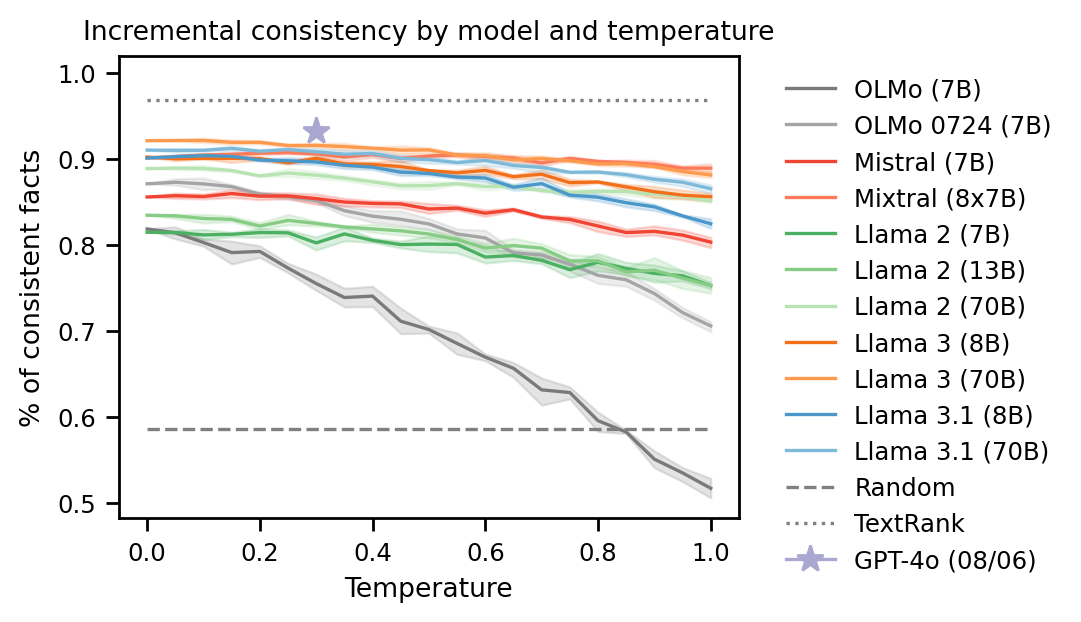

In [18]:
fig = plt.figure(figsize=(4,3))

order = model_ids_to_display_order(df_temp_sweep['model'])
color = model_ids_to_display_color(df_temp_sweep['model'])
df_temp_sweep['model_display'] = model_ids_to_display_name(df_temp_sweep['model'])

ax = sns.lineplot(
    df_temp_sweep,
    x='temperature',
    y='consistency',
    hue='model_display',
    palette=color,
    hue_order=order,
)


scores_fixed = (
    (df_fixed[df_fixed['model'] == 'random']['consistency'].mean(), 'Random', 'gray', 'dashed'),
    (df_fixed[df_fixed['model'] == 'textrank']['consistency'].mean(), 'TextRank', 'gray', 'dotted'),
)

for y, label, color, linestyle in scores_fixed:
    ax.hlines(y, 0, 1, label=label, color=color, linestyles=linestyle)


ax.plot(
    0.3,
    df_fixed[df_fixed['model'] == 'gpt-4o-2024-08-06']['consistency'].mean(),
    label='GPT-4o (08/06)',
    color=COLOR_MAP['gpt-4o-2024-08-06'],
    marker='*',
    markersize=10,
)

plt.ylim(top=1.02)

plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", frameon=False)
plt.title('Incremental consistency by model and temperature')
plt.ylabel('% of consistent facts')
plt.xlabel('Temperature');
# sns.despine()

utils.savefig(fig, name='temperature-ic', formats=['pdf'], path='../output/figures-paper/')

## Relative difference

In [19]:
temp_sweep_models = [
    'Llama-2-13b-chat-hf',
    'Llama-2-70b-chat-hf',
    'Llama-2-7b-chat-hf',
    'Meta-Llama-3-70B-Instruct',
    'Meta-Llama-3-8B-Instruct',
    'Meta-Llama-3.1-70B-Instruct',
    'Meta-Llama-3.1-8B-Instruct',
    'Mistral-7B-Instruct-v0.3',
    'Mixtral-8x7B-Instruct-v0.1',
    'OLMo-7B-0724-Instruct-hf',
    'OLMo-7B-Instruct-hf'
]

df_temp_sweep = df[
    (df['dataset'] == 'pubmed-sample')
    & df['model'].isin(temp_sweep_models)
]

In [20]:
df_grouped = df_temp_sweep.groupby(['model', 'temperature'])['consistency'].mean().unstack(level=1)
df_grouped

temperature,0.00,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,...,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95,1.00
model,,,,,,,,,,,,,,,,,,,,,
Llama-2-13b-chat-hf,0.834470,0.833787,0.830661,0.829683,0.821799,0.828478,0.824902,0.820854,0.818492,0.816330,...,0.806160,0.796354,0.799128,0.796135,0.781277,0.781363,0.768582,0.770385,0.761240,0.752570
Llama-2-70b-chat-hf,0.888767,0.889349,0.888962,0.886487,0.880206,0.883590,0.881114,0.877676,0.873350,0.868707,...,0.871201,0.867872,0.868310,0.862978,0.861052,0.862393,0.861857,0.859029,0.856724,0.851172
Llama-2-7b-chat-hf,0.814660,0.814375,0.811553,0.812286,0.814297,0.813971,0.802268,0.812682,0.805205,0.800299,...,0.800453,0.785806,0.787512,0.781915,0.771150,0.779699,0.772585,0.766785,0.763884,0.752634
Meta-Llama-3-70B-Instruct,0.921222,0.921478,0.921581,0.919335,0.919358,0.915607,0.915822,0.914286,0.912534,0.910273,...,0.904579,0.903742,0.898821,0.900579,0.897835,0.894050,0.894557,0.891135,0.885289,0.881266
Meta-Llama-3-8B-Instruct,0.902164,0.900240,0.900528,0.900600,0.900357,0.895471,0.900697,0.894126,0.893518,0.891116,...,0.883812,0.886710,0.879351,0.882196,0.872349,0.873198,0.867400,0.861870,0.857854,0.856044
Meta-Llama-3.1-70B-Instruct,0.910307,0.909963,0.910069,0.912266,0.908961,0.910866,0.908370,0.905544,0.906365,0.900712,...,0.895772,0.898225,0.892342,0.890099,0.884481,0.884742,0.881650,0.876321,0.872846,0.865301
Meta-Llama-3.1-8B-Instruct,0.901054,0.902611,0.903765,0.902987,0.898632,0.897909,0.896471,0.892603,0.890456,0.884615,...,0.878909,0.877806,0.867024,0.871265,0.857847,0.855454,0.849002,0.844190,0.833687,0.824511
Mistral-7B-Instruct-v0.3,0.855713,0.857162,0.856235,0.859686,0.856643,0.856872,0.853822,0.849789,0.848217,0.847642,...,0.842755,0.836835,0.840867,0.832455,0.829568,0.821951,0.814270,0.815688,0.811326,0.803193
Mixtral-8x7B-Instruct-v0.1,0.901182,0.902676,0.904599,0.905378,0.906703,0.907353,0.905987,0.902230,0.905108,0.900494,...,0.904661,0.902848,0.900938,0.895334,0.900604,0.897136,0.895824,0.893824,0.889275,0.889265


In [21]:
(df_grouped[1] - df_grouped[0])/df_grouped[0]

model
Llama-2-13b-chat-hf           -0.098146
Llama-2-70b-chat-hf           -0.042300
Llama-2-7b-chat-hf            -0.076137
Meta-Llama-3-70B-Instruct     -0.043373
Meta-Llama-3-8B-Instruct      -0.051122
Meta-Llama-3.1-70B-Instruct   -0.049441
Meta-Llama-3.1-8B-Instruct    -0.084949
Mistral-7B-Instruct-v0.3      -0.061375
Mixtral-8x7B-Instruct-v0.1    -0.013223
OLMo-7B-0724-Instruct-hf      -0.189966
OLMo-7B-Instruct-hf           -0.368778
dtype: float64

## Incremental Consistency by Question

In [22]:
runs_json = [
    '../output/pubmed-sample/gpt-4o-2024-08-06/discord-qa-nli/temperature0.3-0.json',
    '../output/pubmed-sample/gpt-4o-2024-08-06/discord-qa-nli/temperature0.3-1.json',
    '../output/pubmed-sample/gpt-4o-2024-08-06/discord-qa-nli/temperature0.3-2.json',
    '../output/pubmed-sample/gpt-4o-2024-08-06/discord-qa-nli/temperature0.3-3.json',
    '../output/pubmed-sample/gpt-4o-2024-08-06/discord-qa-nli/temperature0.3-4.json',
]

In [23]:
df = pd.read_json('../output/pubmed-sample/gpt-4o-2024-08-06/discord-qa-nli/temperature0.3-0.json')
df

,doc_id,cluster_id,question,sent_id,sent,fact,summary_10w_nli_pred,summary_20w_nli_pred,summary_50w_nli_pred,summary_100w_nli_pred,summary_200w_nli_pred
0,38589582,1,What is the main focus of the study?,0,To investigate the effect of an exercise-based...,The effect of an exercise-based cardiac rehabi...,0,1,1,1,1
1,38589582,1,What is the main focus of the study?,0,To investigate the effect of an exercise-based...,The study considers patients with chronic Chag...,0,0,1,1,1
2,38589582,1,What is the main focus of the study?,0,To investigate the effect of an exercise-based...,The study considers the quality of life (QoL) ...,1,1,1,1,1
3,38589582,10,Which patient population is the study concerne...,0,Patients with chronic Chagas cardiomyopathy (C...,Patients have chronic Chagas cardiomyopathy.,0,0,1,1,1
4,38589582,10,Which patient population is the study concerne...,0,Patients with chronic Chagas cardiomyopathy (C...,The patients have CCC stages B2 or C.,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
23119,38507630,2,What limitations or considerations are noted b...,0,No limitations or considerations are explicitl...,No considerations are explicitly noted by the ...,0,0,0,0,0
23120,38507630,2,What limitations or considerations are noted b...,1,"However, the study does mention that the diffe...",The study mentions a difference between the on...,0,1,1,1,1
23121,38507630,2,What limitations or considerations are noted b...,1,"However, the study does mention that the diffe...",The difference is in terms of preventing posto...,0,0,1,1,1
23122,38507630,2,What limitations or considerations are noted b...,1,"However, the study does mention that the diffe...",Ondansetron is better at preventing postoperat...,0,0,0,1,1


In [24]:
df = pd.concat([
    pd.read_json('../output/pubmed-sample/random/discord-qa-nli/output-0.json').assign(model='random'),
    pd.read_json('../output/pubmed-sample/textrank/discord-qa-nli/output.json').assign(model='textrank'),
    pd.read_json('../output/pubmed-sample/gpt-4o-2024-08-06/discord-qa-nli/temperature0.3-0.json').assign(model='gpt-4o-2024-08-06'),
    pd.read_json('../output/pubmed-sample/Meta-Llama-3.1-70B-Instruct/discord-qa-nli/temperature0.3-0.json').assign(model='Meta-Llama-3.1-70B-Instruct'),
])

variables = [
    'summary_10w_nli_pred',
    'summary_20w_nli_pred',
    'summary_50w_nli_pred',
    'summary_100w_nli_pred',
    'summary_200w_nli_pred',
]

df = df.groupby(['question', 'model'])[variables].apply(lambda x: incremental_consistency(x.values, normalize_entailed=True, entail_label=1)[0])
df = df.unstack(level=1)
df = df.rename(MODEL_MAP, axis=1)
display(df.style.format(precision=3).background_gradient(cmap='Blues', axis=None).highlight_null(color="transparent"))

model,Llama 3.1 (70B),GPT-4o (08/24),Random,TextRank
question,,,,
How long was the duration of the intervention or study?,0.893,0.882,0.498,0.974
How were the participants or subjects of the study selected and divided?,0.940,0.964,0.572,0.977
What are secondary outcomes noted in the study?,0.937,0.933,0.597,0.949
What are the detailed findings regarding adverse events or side effects?,0.826,0.926,0.558,0.967
What are the main findings regarding efficacy and safety?,0.876,0.926,0.585,0.951
What are the significant benefits of the intervention?,0.862,0.909,0.570,0.960
What are the specific biological markers influenced by the intervention?,0.933,0.931,0.593,0.958
What condition is being addressed in the study?,0.896,0.915,0.558,0.974
What implications or future recommendations did the study suggest based on its findings?,0.901,0.885,0.630,0.962
